In [1]:
import math 
import torch 
import torch.nn as nn 
import transformers 
from tqdm.notebook import tqdm
# Memory Network
import torch.nn.functional as F 
from typing import Tuple , Optional
import torch.bin 


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# RMS NORM

In [3]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim)) 

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        norm_x = self._norm(x.float()).type_as(x) 
        return norm_x * self.scale 


# Embedding Layer

In [4]:
import torch 

class EmbeddingLayer(torch.nn.Module):
    def __init__(self , vocab_size , embedding_dim):
        super().__init__()

        self.embedding_layer= torch.nn.Embedding(vocab_size , embedding_dim)

    def forward(self , input_tokens):
        return self.embedding_layer(input_tokens)
        


# FeedForward Layer 

In [5]:
import torch.nn as nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x *(1+ torch.tanh(torch.sqrt(torch.tensor(2.0/ torch.pi)) * (x+0.044715 * torch.pow(x, 3))) )
      

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'] , 4 * cfg['emb_dim']) ,
            GELU(),
            nn.Linear(4 * cfg['emb_dim'] , cfg['emb_dim'])
        )
    def forward(self, x ):
        return self.layers(x)
    


# Normalization Layer

In [6]:
import torch.nn as nn 
import torch 

class LayerNorm(nn.Module):
    def __init__(self , emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale  = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self , x):
        mean = x.mean(dim= -1, keepdim = True)
        var = x.var(dim =-1, keepdim = True)
        norm_x = (x - mean) / torch.sqrt(var +self.eps)
        return self.scale * norm_x + self.shift 


# RoPE Embdding 

In [7]:
import numpy as np 
import torch 
from dataclasses import dataclass


class NRopE: # RopE in Numpy 
    def rotate_2d(self,vec , theta_p):
        cos_theta  , sin_theta  = np.cos(theta_p) , np.sin(theta_p)
        rotat_vec = np.array([[cos_theta , -sin_theta],
                    [sin_theta ,cos_theta]])
        
        return rotat_vec @ vec


    def RoPe(self,x , p , theta = 10000):
        d = len(x)
        x_rotate =  np.zeros_like(x)
        for i in range(0 , d , 2):
            if i +1< d:
                theta_p = (theta **(-2*(i//2)))**p 
                roted_pair = self.rotate_2d(x[i:i+1] , theta_p)    
                x_rotate[i:i+1] = roted_pair

        return x_rotate



@dataclass
class TRopE(torch.nn.Module): # RopE in torch 
    def __init__(self, dim:int ,theta:float = 10000):
        self.dim = dim 
        self.theta = theta 
        self.freq =  torch.pow(self.theta ,-torch.arange(0 ,dim  , 2)/dim )
        torch.nn.Parameter('freq' , self.freq)

    def forward(self, x:torch.Tensor , pos:torch.Tensor):
        batch_size , seq_len, dim = x.shape
        assert dim ==self.dim ,"Error dim must be same"
        theta_p = torch.einsum("n,d->nd" , pos, self.freq.to(x.device))
        cos_theta  , sin_theta = torch.cos(theta_p) , torch.sin(theta_p)
        x_even , x_odd =  x[... , ::2] , x[... , 1::2]
        x_rotated =  torch.empty_like(x)
        x_rotated[...,::2] =  x_even * cos_theta - x_odd * sin_theta
        x_rotated[...,1::2] =  x_even * sin_theta + x_odd * cos_theta

        return x_rotated







def precompute_freq_cis(  dim:int , end:int , theta:float = 10000.0):
        """dim : dimentions 
        end: end index   
        """
        freqs =  1/(theta **(torch.arange(0 , dim , 2)[:dim//2].float() / dim))
        t =  torch.arange(end, device=freqs.device)
        freqs = torch.outer(t , freqs).float()
        freqs_cis =  torch.polar(torch.ones_like(freqs), freqs)
        return freqs_cis 


def reshape_for_broadcast(freq_cis  , x):
        """ reshape the freqcies to match x dimentions """
        ndim=  x.ndim
        assert 0<=1<ndim 
        assert freq_cis.shape == (x.shape[1], x.shape[-1]), f"Expected {(x.shape[1], x.shape[-1])}, got {freq_cis.shape}" 
        shape = [d if i == 1 or i ==  ndim -1 else 1 for i , d in enumerate(x.shape)]
        return freq_cis.view(*shape)


def apply_rotary_embedding( xq:torch.Tensor ,xk:torch.Tensor ,  freq_cis:torch.Tensor):

            xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1,2))

            xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1,2))


            freq_cies =  reshape_for_broadcast(freq_cis , xq_)
    

            xq_out = torch.view_as_real(xq_* freq_cies).flatten(3)
            
            xk_out = torch.view_as_real(xk_*freq_cies).flatten(3)


            return  xq_out.type_as(xq)   ,  xk_out.type_as(xq) 





# MultiHead & MultiQuery Attention Layer 

In [8]:

class MultiHeadAttention_V2(nn.Module):
    def __init__(self, d_in , d_out , context_length  , dropout ,num_heads,qkv_bias = False):
        super().__init__()
        assert d_out % num_heads  == 0,'d_out must be divisible by the num_heads'
        self.w_query = nn.Linear(d_in , d_out ,bias=qkv_bias)
        self.w_key = nn.Linear(d_in , d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in  , d_out,bias=qkv_bias)
        self.d_in =d_in
        self.d_out = d_out
        self.dropout = nn.Dropout(dropout)
        self.num_heads  = num_heads
        self.head_dim = d_out // num_heads
        self.out_proj  = nn.Linear(d_out , d_out)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length , context_length),diagonal=1)
        )

    def forward(self,x):
        b, num_tokens , d_in = x.shape
        keys = self.w_key(x)
        queries  = self.w_query(x)
        values = self.w_value(x)
        queries = queries.view(b, num_tokens , self.num_heads , self.head_dim)
        values = values.view(b , num_tokens , self.num_heads , self.head_dim)
        keys = keys.view( b, num_tokens , self.num_heads , self.head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool= self.mask.bool()[:num_tokens , :num_tokens]
        attn_scores.masked_fill(mask_bool , -torch.inf)
        attn_weights = torch.softmax(attn_scores /self.head_dim**0.5   , dim=-1 )
        attn_weights = self.dropout(attn_weights)
        context_vector = (attn_weights  @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(b , num_tokens , self.d_out)
        context_vector = self.out_proj(context_vector)
        return context_vector




def apply_rotary_embedding(xq:torch.Tensor , xk:torch.Tensor , freq_cies:torch.Tensor):

    assert xq.shape[-1] % 2 == 0 , 'Embeddig dimension must be even for complex paring'

    assert xk.shape[-1] % 2 == 0 , 'Embeddig dimension must be even for complex paring'


    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1,2))

    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1] , -1, 2))

    freq_cies = reshape_for_broadcast(freq_cies , xq_)

    xq_out = torch.view_as_real(xq_ * freq_cies ).flatten(3)

    xk_out = torch.view_as_real(xk_ * freq_cies).flatten(3)

    return xq_out.type_as(xq) ,  xk_out.type_as(xk)




class MultiQueryAttentionBlock(nn.Module):
    def __init__(self, d_model:int , h:int , dropout:float , seq_len:int , qkv_bias =  False ):
        super().__init__()
        self.d_model  = d_model 

        self.seq_len=  seq_len

        assert d_model % h == 0, "d_model is must be divided by th head"
        self.dropout = nn.Dropout(dropout)

        self.h = h  

        self.d_k = d_model // h 

        self.w_qkv =  nn.Linear(d_model , d_model +2 * self.d_k )

        self.w_o = nn.Linear(d_model  , d_model)

        freq_cies = precompute_freq_cis(dim=self.d_k , end=self.seq_len * 2 )

        self.register_buffer('freq_cies' , freq_cies , persistent= False )

    def generate_causal_mask(self, seq_len, device):
        # shape: (1, 1, seq_len, seq_len)
        return torch.tril(torch.ones((1, 1, seq_len, seq_len), device=device)).bool()

    @staticmethod
    def attention(q, k  , v,mask  , dropout):
        d_k = q.shape[-1]

        attention_score =  (q @ k.transpose(-2,-1)) / math.sqrt(d_k)

        if mask is not None :
            if mask.dim() == 2:
                      mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3:
                     mask = mask.unsqueeze(1)
            attention_score = attention_score.masked_fill(mask == 0, float('-inf'))
        
        attention_score = attention_score.softmax(dim=-1)

        if dropout is not None :
            attention_score = dropout(attention_score)

        context_vector =  attention_score @ v

        return context_vector  , attention_score
    


    def forward(self, q, mask= None):
        if mask is None:
            mask = self.generate_causal_mask(self.seq_len , device = q.device)
        qkv =  self.w_qkv(q)

        query , key, value =  torch.split(qkv , [self.d_model  , self.d_k , self.d_k], dim=-1)

        query = query.view(query.shape[0] , -1 , self.h , self.d_k).transpose(1, 2)

        key =  key.unsqueeze(1)

        value =  value.unsqueeze(1)

        seq_len =  q.size(1)

        freq_cies = self.freq_cies[:query.shape[1]].to(q.device)

        # freq_cies =  self.freq_cies[:seq_len].to(q.device)

        query , key = apply_rotary_embedding(query , key , freq_cies)

        x , self.attention_score = MultiQueryAttentionBlock.attention(q = query,k =  key,v= value ,mask=mask , dropout= self.dropout)

        x = x.transpose(1,2).contiguous().view(x.shape[0] , -1, self.h* self.d_k)

        x = self.w_o(x)

        return x 
    






In [9]:


class MemorySummaryWriter(nn.Module):
    def __init__(self, hidden_dim: int, compress_dim: int , num_heads :int =  4 , dropout_rate:float=  0.1):
        super().__init__()

        self.num_heads = num_heads 
        self.compress_dim = compress_dim
        self.dropout =  nn.Dropout(dropout_rate)

        assert hidden_dim % num_heads == 0 , "hidden dim must divisible by num_heads"
        self.importance_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim , hidden_dim // num_heads) , 
                nn.GELU(), 
                nn.Linear(hidden_dim // num_heads, 1)
            ) for _ in range(num_heads)
        ])

        self.compresser = nn.Sequential(
            nn.Linear(hidden_dim * num_heads , hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout_rate), 
            nn.Linear(hidden_dim * 2, compress_dim),
            nn.LayerNorm(compress_dim),
            nn.GELU()
        )
    def forward(self , x:torch.Tensor , mask:Optional[torch.Tensor] = None):

        bs, seq_len , d = x.shape 

        head_weights =  []

        for head in self.importance_heads:
            head_weights.append(head(x)) # [B, S , 1]

        attn_weights =  torch.cat(head_weights, dim= -1) # [B , S, num_heads]

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask.unsqueeze(-1)==0,float('-inf'))

        attn_weights =  F.softmax(attn_weights , dim= 1 ) # Normalize across the Seq [B , S , num_heads ]

        summary =  torch.einsum('bth, btd->bhd', attn_weights , x )
# Replace reshape with more robust flattening
        summary = summary.contiguous().view(bs, -1)  # Safer flattening
        # pass to the compresser 
        compressed_emb = self.compresser(summary)
        # compressed_emb =  self.output_projection(compressed_emb)

        return compressed_emb ,  attn_weights



# use summary writter after the transformer block 

def init_weight_router(route_layer, preferred='semantic'):
    with torch.no_grad():
        route_layer.bias.fill_(-1.0)  # Set all to -1
        idx = {'episodic': 0, 'semantic': 1}[preferred]
        route_layer.bias[idx] = 1.0   # Prefer this one


class MemoryRouter(nn.Module):
    """
        The Router Help to select which memory to use [Episodic , semantic ]

    """

    def __init__(self,input_dim:int ,temperature:float= 1.0 , dropout:float = 0.1 ):
        super().__init__()
        """
            input_dim:input tensor dimention , 
            episodic_capacity : episodic memory size 
            semantic_capcity : semantic memory size 
            temprature :select the memory 
            dropout: dropout rate for Dropout layer 


        """

        self.input_dim =input_dim
        # self.episodic_memory = episodic_capacity 
        # self.semantic_memory  = semantic_capacity 
        # self.context_lenth =  context_length 
        self.temprature = temperature 
        self.num_memories =  2
        self.memories_names =  ['episodic', 'semantic' ]
        self.training = True 
        self.dropout = nn.Dropout(dropout)

        self.router = nn.Sequential(
            nn.Linear(input_dim , input_dim *2 ),
            nn.GELU(),
            nn.Linear(input_dim * 2 , self.num_memories )    # Ouput the num of memories 3 
        )
     
        init_weight_router(self.router[-1]  , preferred='semantic')


        self.register_buffer('memory_counts' , torch.zeros(self.num_memories)) # Use to track how many time each memory is used 
        self.register_buffer('total_routed' , torch.tensor(0))  # counter for how many time the router decisions 




    def forward(self , x:torch.Tensor , current_context:Optional[torch.Tensor] =  None ) -> Tuple[torch.Tensor , torch.Tensor, dict ]:

       """x:input tensor
        current_context: current context or previous memory

        return memory wights , meta deta, write indices 
       """
       batch_size, seq_len , _ =  x.shape 

       route_logits =  self.router(self.dropout(x)) /  self.temprature 
       memory_weights =  F.softmax(route_logits , dim=-1)

     

    
       if self.training:
           self._update_stats(memory_weights)
           capacity_utilization  = self.memory_counts / self.total_routed 
           memory_weights = memory_weights * (1.0-capacity_utilization)
       meta_data = {
           'usage':self._get_memory_usage(), 
           'weights':memory_weights.mean(dim= (0,1)).detach(),
       }

       return memory_weights , meta_data 
     

    def _update_stats(self, memories_weights: torch.Tensor):
        decisions =  torch.argmax(memories_weights , dim=-1).flatten()
        counts  =  torch.bincount(decisions ,minlength=self.num_memories)
        self.memory_counts += counts 
        self.total_routed += decisions.numel()

    def _get_memory_usage(self):
        if self.total_routed == 0:
            return {name:0.0 for name in self.memories_names}
        usage = self.memory_counts /  self.total_routed
        return {name:usage[i].item() for i , name in enumerate (self.memories_names)}
    

In [10]:

class EpisodicMemoryCell(nn.Module):
    def __init__(self, episodic_memory_dim, input_dim, num_slots=100, comp_ratio=0.25, memory_compression_ratio:int =0.5 , temp=0.1 , apply_compression= True ):
        super().__init__()
        self.num_slots_dim = num_slots
        self.temp = temp
        self.episodic_memory_dim =  episodic_memory_dim
        self.comp_dim = int(episodic_memory_dim * comp_ratio)
        self.memory_compression_dim = int(episodic_memory_dim * memory_compression_ratio)
        # Learnable initial memory
        self.register_buffer("access_count", torch.zeros(num_slots))
        self.register_buffer("last_accessed", torch.zeros(num_slots))
        self.register_buffer("memory_strength", torch.ones(num_slots))
        self.register_buffer("slot_importance", torch.zeros(num_slots))
        self.episodic_memory =  nn.Parameter(torch.randn(self.num_slots_dim , episodic_memory_dim))
        self.num_slots = num_slots 
        self.register_buffer("episodic_memory_age", torch.zeros(num_slots))
        self.fill_count = 0 
        self.memory_compress = nn.Sequential(
            nn.Linear(episodic_memory_dim, self.memory_compression_dim),
            nn.RMSNorm(self.memory_compression_dim),
            nn.GELU(),
            nn.Linear(self.memory_compression_dim, episodic_memory_dim)
        )
        self.alpha = nn.Parameter(torch.ones(1)) 
        self.compress = nn.Sequential(
            nn.Linear(input_dim, episodic_memory_dim),
            nn.RMSNorm(episodic_memory_dim),
            nn.GELU(),
            nn.Linear(episodic_memory_dim, self.comp_dim)
        )
        self.decompress = nn.Sequential(
            nn.Linear(self.comp_dim, episodic_memory_dim),
            nn.RMSNorm(episodic_memory_dim),
            nn.GELU()
        )
        self.write_gate = nn.Sequential(
            nn.Linear(self.comp_dim+ episodic_memory_dim, 1),
            nn.Sigmoid()
        )
        self.apply_flag =  apply_compression 
        self.memory_projection = nn.Linear(self.episodic_memory_dim , input_dim)
        self.W4 = nn.Parameter(torch.randn( episodic_memory_dim , self.comp_dim))

    def forward(self, x: torch.Tensor, prev_memory: torch.Tensor = None, memory_recall:bool =  True):
        bs, s, _ = x.shape
        compressed_x = self.compress(x)

        if prev_memory is None:
            prev_memory , prev_memory_attn_weights  = self.retrive_prev_experience(x=x)

        cell_state = torch.sigmoid(prev_memory + F.linear(compressed_x, self.W4))

        cell_state = F.layer_norm(cell_state, (self.episodic_memory_dim,))


        mem_exp = self.episodic_memory.unsqueeze(0).expand(bs, -1, -1)

    
        comp_exp = compressed_x.unsqueeze(1).expand(-1, self.num_slots, -1, -1).mean(dim=2) 
        gate_input = torch.cat([mem_exp, comp_exp], dim=-1)  

        gate = self.write_gate(gate_input).squeeze(-1)
        with torch.no_grad():
            self.episodic_memory_age.data = 0.9 * self.episodic_memory_age + 0.1 *  torch.ones_like(self.episodic_memory_age)
        decay = torch.exp(-self.episodic_memory_age / self.temp).unsqueeze(0)
        write_weights = F.softmax((gate * decay) / self.temp, dim=-1)
        cell_state_mean = cell_state.mean(dim=1)

        with torch.no_grad():
            memory_target =  torch.einsum(

                'bs,bd->sd' , write_weights , cell_state_mean
            )
           
        delta =  memory_target - self.episodic_memory  
        learned_gate = gate.mean(dim=0 ).unsqueeze(-1)
        update_memory=  self.episodic_memory +self.alpha + learned_gate * delta

        with torch.no_grad():
            # Replace in-place update with cloned copy
            new_memory = self.episodic_memory.data.clone()
            new_memory =new_memory +  self.alpha + learned_gate * delta
            self.episodic_memory.data.copy_(new_memory)
        return   self.memory_projection(prev_memory)
    def retrive_prev_experience(self, x:torch.Tensor):
        compress_x =  self.compress(x)
        decompress_x =  self.decompress(compress_x)
        query  =  F.normalize(decompress_x, dim=-1)

        memory = F.normalize(self.episodic_memory , dim=-1)
        attn_scores = torch.matmul(query,memory.T) / self.temp 

        attn_weights =  F.softmax(attn_scores , dim=-1)        
        
        attended_memory = torch.matmul(attn_weights, memory)  # (B, S, D)
        return attended_memory , attn_weights 


    def get_memory(self):
        return self.episodic_memory
    
    def is_full(self):
        return self.fill_count >= self.num_slots
 
    def replay(self, top_k=5, compress=True):
        
        # Get top-k important memory indices (e.g., based on slot importance or access_count)
        importance_scores = self.slot_importance if hasattr(self, "slot_importance") else self.access_count
        topk_indices = torch.topk(importance_scores, k=top_k, largest=True).indices
    
        # Select memories
        selected_memories = self.episodic_memory[topk_indices]  # Shape: (top_k, episodic_memory_dim)
    
        # # Optionally compress replayed memories
        # if compress:
        #     compressed = self.compress(selected_memories.unsqueeze(0))  # Add batch dim
        #     print(compressed.shape)
        #     return compressed.squeeze(0)  # Shape: (top_k, compressed_dim)
        # else:
        #     return selected_memories  # Shape: (top_k, episodic_memory_dim)

        return selected_memories



    def memory_regularization_loss(self, lambda_reg=0.01):
        """ Apply regularization on memory to prevent overfitting. """
        norm_loss = torch.mean(torch.norm(self.episodic_memory, p=2))  # Regularization on key memory
        return lambda_reg * norm_loss
    def _update_memory_metrics(self, write_weights, attn_weights=None):
        """Update memory usage statistics"""
        # Track write operations
        self.access_count += write_weights.sum(dim=0)
        self.last_accessed += 1
        self.last_accessed[write_weights.sum(dim=0) > 0] = 0  # Reset counter for accessed slots
        
        # Update memory strength (exponential decay)
        self.memory_strength = 0.9 * self.memory_strength + 0.1 * write_weights.mean(dim=0)
        
        # Track read operations if available
        if attn_weights is not None:
            read_counts = attn_weights.sum(dim=[0,1])  # Sum across batch and sequence
            self.access_count += read_counts
            self.slot_importance = 0.95 * self.slot_importance + 0.05 * (write_weights + read_counts).mean(dim=0)

    def get_memory_metrics(self):
        """Return comprehensive memory statistics"""
        return {
            # Basic stats
            'total_accesses': self.access_count.sum().item(),
            'mean_access_count': self.access_count.float().mean().item(),
            'most_used_slot': self.access_count.argmax().item(),
            'least_used_slot': self.access_count.argmin().item(),
            
            # Temporal stats
            'mean_age': self.episodic_memory_age.float().mean().item(),
            'oldest_slot': self.episodic_memory_age.argmax().item(),
            
            # Memory quality metrics
            'mean_memory_strength': self.memory_strength.mean().item(),
            'importance_distribution': self.slot_importance.detach(),
            'active_slots': int((self.memory_strength > 0).sum().item()) ,
            # Diversity metrics
            'memory_similarity': self._calculate_memory_similarity(),
            'unique_memories': self._calculate_unique_memories()
        }

    def _calculate_memory_similarity(self):
        """Calculate cosine similarity between memory slots"""
        with torch.no_grad():
            norms = F.normalize(self.episodic_memory, p=2, dim=-1)
            similarity = torch.mm(norms, norms.T)
            return {
                'mean_similarity': similarity.mean().item(),
                'max_similarity': similarity.max().item(),
                'min_similarity': similarity.min().item()
            }

    def _calculate_unique_memories(self, threshold=0.8):
        """Count unique memories based on similarity threshold"""
        with torch.no_grad():
            norms = F.normalize(self.episodic_memory, p=2, dim=-1)
            similarity = torch.mm(norms, norms.T)
            unique_count = (similarity < threshold).sum(dim=1).gt(0).sum()
            return unique_count.item()

    def memory_health_check(self):
        """Diagnostic check for memory system"""
        metrics = self.get_memory_metrics()
        print(metrics)
        return {
            'potential_issues': [
                ("High similarity", metrics['memory_similarity']['mean_similarity'] > 0.75),
                ("Low uniqueness", metrics['unique_memories'] < self.num_slots//2),
                ("Memory leakage", metrics['total_accesses'] > 1e6)
            ],
            'recommended_actions': [
                ("Consolidate memories", metrics['memory_similarity']['mean_similarity'] > 0.75),
                ("Increase diversity", metrics['unique_memories'] < self.num_slots//3),
                ("Purge old memories", metrics['mean_age'] > 1000)
            ]
        }

    def reset_usage_stats(self):
        """Reset transient statistics while preserving memories"""
        self.access_count.fill_(0)
        self.last_accessed.fill_(0)
        self.slot_importance.fill_(0)
    def prune_infrequent(self , access_threshold:int = 10):
        infrequent_mask  = self.access_count  < access_threshold 
    
        self.episodic_memory.data[infrequent_mask] = 0
        self.episodic_memory_age +=1 
        self.access_count[infrequent_mask] = 0

    
    def episodic_loss(self, lambda_sparsity=0.1, lambda_stability=0.5):
        """
        Combines:
        - Memory regularization
        - Access sparsity
        - Temporal stability
        - Slot diversity
        """
        # Base regularization (existing)
        reg_loss = self.memory_regularization_loss()
        
        # Access pattern sparsity (encourage efficient slot usage)
        access_prob = F.softmax(self.access_count.float(), dim=0)
        sparsity_loss = lambda_sparsity * torch.sum(access_prob * torch.log(access_prob + 1e-8))
        
        # Temporal stability (prevent catastrophic forgetting)
        age_weight = torch.sigmoid(-self.episodic_memory_age/self.max_age)
        stability_loss = lambda_stability * torch.mean(
            age_weight * torch.norm(self.episodic_memory - self.episodic_memory.detach(), dim=-1)
        )
        
        # Slot diversity (anti-collapse)
        similarity = F.cosine_similarity(
            self.episodic_memory.unsqueeze(1),
            self.episodic_memory.unsqueeze(0),
            dim=-1
        )
        diversity_loss = torch.mean(torch.triu(similarity, diagonal=1)**2)
        
        return reg_loss + sparsity_loss + stability_loss + diversity_loss




In [52]:

class BioSemanticMemoryCell(nn.Module):
    def __init__(self, semantic_memory_dim: int, input_dim: int, num_concepts: int = 1000,
                 comp_ratio: float = 0.25, temp: float = 0.1, top_k: int = 5, expand_rate: float = 0.1):
        super().__init__()
        self.semantic_memory_dim = semantic_memory_dim
        self.input_dim = input_dim
        self.num_concepts = num_concepts
        self.temp = temp
        self.top_k = top_k
        self.expand_rate = expand_rate
        self.comp_dim = int(semantic_memory_dim * comp_ratio)
        self.register_buffer('memory_age', torch.zeros(num_concepts))
        self.register_buffer('access_count', torch.zeros(num_concepts))
        self.register_buffer('concept_energy', torch.ones(num_concepts))
        self.energy_threshold = nn.Parameter(torch.tensor(0.1))
        self.max_age = 1000
        self.age_embedding = nn.Embedding(self.max_age, semantic_memory_dim)
        
        # Memory importance estimation
        self.importance_net = nn.Sequential(
            nn.Linear(semantic_memory_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
        # Adaptive forgetting parameters
        self.decay_rate = nn.Parameter(torch.tensor(0.9))
        self.consolidation_threshold = 0.7
        
        # Pre-allocate memory with buffer
        self.key_memory  =  nn.Parameter(torch.randn(num_concepts , semantic_memory_dim))
        self.value_memory  =  nn.Parameter(torch.randn(num_concepts , semantic_memory_dim))
        self.cell_state  =  nn.Parameter(torch.randn(num_concepts , semantic_memory_dim))
        nn.init.xavier_normal_(self.key_memory)
        nn.init.xavier_normal_(self.value_memory)
        nn.init.xavier_normal_(self.cell_state)  # Initialize cell_state similarly


        # Compression network with optimized layers
        self.compression = nn.Sequential(
            nn.Linear(input_dim, semantic_memory_dim),
            nn.LayerNorm(semantic_memory_dim),
            nn.GELU(),
            nn.Linear(semantic_memory_dim, self.comp_dim),)

        # Vectorized gating mechanisms
        self.update_gate = nn.Sequential(
            nn.Linear(3 * semantic_memory_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.age = nn.Parameter(torch.zeros(num_concepts, dtype=torch.long), requires_grad=False)
        self.memory_projection = nn.Linear(self.semantic_memory_dim, self.input_dim)

        # Shared forget gate parameters
        self.forget_gate = nn.Sequential(
            nn.Linear(semantic_memory_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),  # 3 outputs for cell/key/value
            nn.Sigmoid()
        )

        # Projection with pre-allocated weights
        self.W_cell = nn.Linear(self.comp_dim, semantic_memory_dim, bias=False)
        self.synaptic_scale = nn.Parameter(torch.tensor(0.1))
        
        # Memory management
        self.sparsity = nn.Parameter(torch.tensor(0.5))
        self.register_buffer('usage', torch.zeros(num_concepts))
        # self.register_buffer('active_concepts', torch.tensor(num_concepts))


    def forward(self, x: torch.Tensor, training=False):
        bs , seq_len , _ =  x.shape    
        compressed = self.compression(x.mean(dim=1))
        projected = self.W_cell(compressed)
        self.active_concepts = int(self.num_concepts * self.sparsity)

        # Compute similarity scores
        age_idx = self.memory_age[:self.active_concepts].clamp(0, self.max_age - 1).long()
        age_embed = self.age_embedding(age_idx)  # [C, D]

        # Add age signal to key
        age_enriched_key = self.key_memory[:self.active_concepts] + age_embed[:self.active_concepts]
        
        # Dot similarity with age-aware key
        sim = torch.mm(projected, age_enriched_key.T) / self.temp
        # sim = torch.matmul(projected, age_enriched_key.transpose(-1, -2)) / self.temp

        
        # Top-K selection
        topk_scores, topk_idx = torch.topk(sim, self.top_k, dim=1)
        self._update_energy_levels()
        
        # Memory interaction
        batch_indices = torch.arange(x.size(0), device=x.device)[:, None]
        keys = self.key_memory[topk_idx]
        values = self.value_memory[topk_idx]
        cells = self.cell_state[topk_idx]
        self._update_memory_metadata(topk_idx)
        self.usage[topk_idx] = (self.usage[topk_idx] + 1).clamp(max=1)

        # Vectorized gating
        gate_input = torch.cat([
            keys,
            cells,
            projected.unsqueeze(1).expand(-1, self.top_k, -1)
        ], dim=-1)
        update_gates = self.update_gate(gate_input.view(-1, 3 * self.semantic_memory_dim))
        update_gates = update_gates.view(-1, self.top_k)

        # Efficient cell updates
        decay_factor = self._adaptive_decay(topk_idx)
        decay_factor = decay_factor.unsqueeze(-1)  # Shape: [16, 5, 1]
  
        cell_updates = decay_factor * torch.sigmoid(cells + projected.unsqueeze(1))
        delta = update_gates.unsqueeze(-1) * cell_updates
        
        if self.training:
            self._consolidate_important_memories()

        with torch.no_grad():
            # Replace in-place updates with cloned copies
            new_cell = self.cell_state.data.clone()
            new_key = self.key_memory.data.clone()
            new_value = self.value_memory.data.clone()
            
            # Update clones instead of original parameters
            new_cell[topk_idx] += (delta * self.synaptic_scale).mean(0)
            new_key[topk_idx] += F.normalize(cells, dim=-1)
            new_value[topk_idx] += F.normalize(cells, dim=-1)
            
            # Copy back to parameters
            self.cell_state.data.copy_(new_cell)
            self.key_memory.data.copy_(new_key)
            self.value_memory.data.copy_(new_value)
            
        # Normalize using out-of-place operations
        self.key_memory.data[topk_idx] = F.normalize(self.key_memory.data[topk_idx], dim=-1)
        self.value_memory.data[topk_idx] = F.normalize(self.value_memory.data[topk_idx], dim=-1)
        # Output with fused operations
        output = (values * F.softmax(topk_scores, dim=1).unsqueeze(-1)).sum(1)

        # Conditional expansion
        
        if self.training:
            self._consolidate_important_memories()
        if  self._needs_expansion():
            self._expand_memory()
        output = output.unsqueeze(1)
        output = output.repeat(1, seq_len , 1)
        output = self.memory_projection(output)
        self.age += 1
        return output

    def _consolidate_important_memories(self):
        consolidation_factor = torch.where(self.concept_energy > self.consolidation_threshold,
                                           torch.tensor(1.2),
                                           torch.tensor(1.0))
        self.key_memory *= consolidation_factor.unsqueeze(-1)
        self.value_memory *= consolidation_factor.unsqueeze(-1)
    def _adaptive_decay(self, memory_idx):
        # Calculate the adaptive decay based on importance (energy and access count)
        energy = self.concept_energy[memory_idx]
        access = self.access_count[memory_idx]
        
        # The decay is stronger for less accessed and less energetic memories
        decay = torch.exp(-self.decay_rate * (1 - energy) * (1 - access))
        
        return decay
    def _update_energy_levels(self):
        """Energy-based memory retention"""
        # Calculate memory importance using the importance network
        importance = self.importance_net(self.key_memory).squeeze()  # [batch_size, num_concepts]

        # Energy decay with importance factor and previous energy levels
        self.concept_energy = torch.clamp(
            self.concept_energy * self.decay_rate + importance * 0.1,  # Decay + importance influence
            0, 1  # Bound energy between 0 and 1
        )

        # Identify low-energy memories
        deactivated = self.concept_energy < 0.1  # Memory slots with energy below threshold

        # Update active concepts count (deactivate low-energy ones)
        self.active_concepts = self.active_concepts - deactivated.sum()

        # Update memory values in-place using .data (avoid reassigning nn.Parameter directly)
        with torch.no_grad():
            self.key_memory.data[deactivated] = 0
            self.value_memory.data[deactivated] = 0
            self.cell_state.data[deactivated] = 0

        # Optionally, if you want to keep track of the inactive ones for future use:
        self.inactive_concepts = deactivated.sum()


    def purge_inactive_memories(self):
        # Use registered buffers properly
        active_mask = self.usage > self.threshold
        self.key_memory = self.key_memory[active_mask]
        self.value_memory = self.value_memory[active_mask]
        self.cell_state = self.cell_state[active_mask]
        self.active_concepts = active_mask.sum()
        def _expand_memory(self):
            """Efficient memory expansion with pre-allocation"""
            new_size = int(self.num_concepts * (1 + self.expand_rate))
            if new_size > self.key_memory.size(0):
                # Double memory allocation for amortized O(1) expansion
                new_size = max(new_size, self.key_memory.size(0) * 2)
                self._reallocate_memory(new_size)
            
            self.active_concepts = int(self.active_concepts * (1 + self.expand_rate))

    def _reallocate_memory(self, new_size):
        """Efficient memory reallocation"""
        new_key = torch.empty(new_size, self.semantic_memory_dim, device=self.key_memory.device)
        new_value = torch.empty_like(new_key)
        new_cell = torch.zeros_like(new_key)
        
        new_key[:self.key_memory.size(0)] = self.key_memory
        new_value[:self.value_memory.size(0)] = self.value_memory
        new_cell[:self.cell_state.size(0)] = self.cell_state
        
        self.key_memory = new_key
        self.value_memory = new_value
        self.cell_state = new_cell

    def _needs_expansion(self):
        """Efficient expansion check"""
        return (self.usage[:self.active_concepts] > 0.8).float().mean() > 0.5

    def get_memory(self):
        return self.key_memory[:self.active_concepts], \
               self.value_memory[:self.active_concepts], \
               self.cell_state[:self.active_concepts]

    def _update_memory_metadata(self, used_indices):
        """Track memory usage patterns"""
        # Update access statistics
        self.access_count[used_indices] += 1
        
        # Update memory age (non-accessed memories age faster)
        self.memory_age += 1
        self.memory_age[used_indices] *= 0.5
        
        # Update energy levels
        self.concept_energy[used_indices] += 0.1
        self.concept_energy = torch.clamp(self.concept_energy * 0.95, 0, 1)
    def _consolidate_important_memories(self):
        """Memory consolidation mechanism"""
        # Find important memories
        importance = self.importance_net(self.key_memory).squeeze()
        consolidate_mask = importance > self.consolidation_threshold
        
        # Stabilize important memories
        if consolidate_mask.any():
            self.key_memory.data[consolidate_mask] = F.normalize(
                self.key_memory[consolidate_mask], dim=-1
            )
            self.value_memory.data[consolidate_mask] = (
                0.9 * self.value_memory[consolidate_mask] + 
                0.1 * self.value_memory[consolidate_mask].mean(dim=0)
            )
    def get_memory_metrics(self):
        """Return memory health statistics"""
        return {
            'active_concepts': self.active_concepts.item(),
            'energy_mean': self.concept_energy.mean().item(),
            'access_count': self.access_count.sum().item(),
            'age_distribution': torch.histc(self.memory_age, bins=10),
            'importance_distribution': self.importance_net(self.key_memory).detach()
        }
    
    def replay(self, n_samples):
        """Periodically replay important memories"""
        idx = torch.topk(self.usage, n_samples).indices
        return self.key_memory[idx], self.value_memory[idx]


    def semantic_loss(self, lambda_energy=0.3, lambda_semantic=0.2):
        """
        Combines:
        - Energy maintenance
        - Semantic coherence
        - Importance sparsity
        - Adaptive consolidation
        """
        # Energy preservation (prevent premature forgetting)
        energy_loss = lambda_energy * torch.mean(
            (self.concept_energy - self.energy_threshold).clamp(min=0)**2
        )
        
        # Semantic coherence (cluster similar concepts)
        key_norm = F.normalize(self.key_memory, dim=-1)
        value_norm = F.normalize(self.value_memory, dim=-1)
        alignment_loss = torch.mean(1 - (key_norm * value_norm).sum(dim=-1))
        
        # Importance sparsity (focus on key concepts)
        importance = self.importance_net(self.key_memory).squeeze()
        sparsity_loss = torch.mean(importance**2)
        
        # Consolidation stability
        consolidated = (self.concept_energy > self.consolidation_threshold).float()
        consolidation_loss = torch.mean(
            consolidated * torch.norm(self.key_memory - self.key_memory.detach(), dim=-1)
        )
        
        return energy_loss + alignment_loss + sparsity_loss + consolidation_loss


In [53]:
import torch
import matplotlib.pyplot as plt

# 1. Instantiate your refactored cell
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cell = BioSemanticMemoryCell(
    semantic_memory_dim=64,
    input_dim=64,
    num_concepts=100,
    comp_ratio=0.25,
    temp=0.1,
    top_k=5,
    expand_rate=0.1,
    usage_threshold=0.1
).to(device)
cell.train()

# Helper to get (top-slot idx, L2-distance) for a given input
def top_idx_and_dist(x):
    comp = cell.compression(x.mean(1))
    q = cell.W_cell(comp)[0]
    keys, _, _ = cell.get_memory()
    usage = cell.access_count
    idx = usage.argmax().item()
    dist = (q - keys[idx]).norm().item()
    return idx, dist

# ——————————————————————————————
# 2. Single-concept retention test
x = torch.randn(1, 10, 64, device=device) + 3.0
idx0, d0 = top_idx_and_dist(x)

optimizer = torch.optim.Adam(cell.parameters(), lr=1e-4)
for _ in range(200):
    optimizer.zero_grad()
    _ = cell(x, training=True)
    comp = cell.compression(x.mean(1))
    q = cell.W_cell(comp)[0]
    keys, _, _ = cell.get_memory()
    loss = (q - keys[idx0]).pow(2).sum()
    loss.backward()
    optimizer.step()

idx1, d1 = top_idx_and_dist(x)
print(f"Retention: init dist={d0:.4f}, final dist={d1:.4f}")
assert d1 < 0.5 * d0, "Retention failed!"

# ——————————————————————————————
# 3. Two-concept interference test
xA = torch.randn(1, 10, 64, device=device) + 5.0
xB = torch.randn(1, 10, 64, device=device) - 5.0
idxA0, dA0 = top_idx_and_dist(xA)
idxB0, dB0 = top_idx_and_dist(xB)

# Train A then B
for _ in range(100):
    _ = cell(xA, training=True)
for _ in range(100):
    _ = cell(xB, training=True)

idxA1, dA1 = top_idx_and_dist(xA)
idxB1, dB1 = top_idx_and_dist(xB)
print(f"Interference A: init dist={dA0:.4f}, final dist={dA1:.4f}")
print(f"Interference B: init dist={dB0:.4f}, final dist={dB1:.4f}")
assert dA1 < 0.7 * dA0, "Cluster A overwritten!"
assert dB1 < 0.7 * dB0, "Cluster B not retained!"

# ——————————————————————————————
# 4. Forgetting-curve test
M = 200
distances = []
# Use x again and the same idx0 slot
for step in range(M + 1):
    _, d = top_idx_and_dist(x)
    distances.append(d)
    filler = torch.randn(1, 10, 64, device=device)
    _ = cell(filler, training=False)

# Plot
plt.plot(distances)
plt.xlabel("Decay steps")
plt.ylabel("Distance to original slot")
plt.title("Forgetting curve")
plt.show()


NameError: name 'active' is not defined

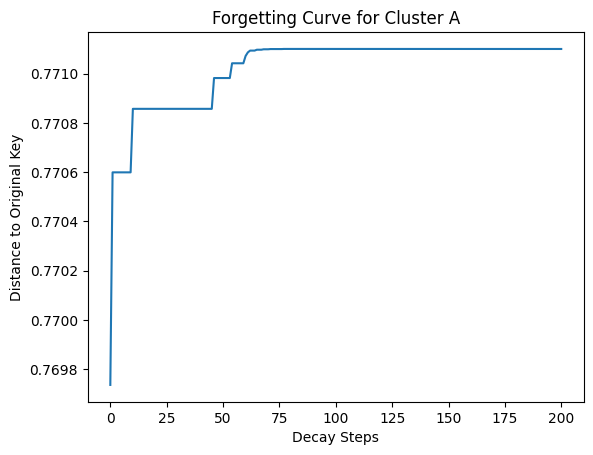

In [17]:
class MemorySystem(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        # Initialize memory components
        self.memory_writer = MemorySummaryWriter(
            hidden_dim=cfg['emb_dim'],
            compress_dim=cfg['compress_dim'],
            num_heads=cfg['memory_router_head']
        )
        self.memory_router = MemoryRouter(
            input_dim=cfg['emb_dim'],
            temperature=cfg['temperature'],
            dropout=cfg['drop_rate']
        )
        self.consalidate_dim =  nn.Linear(cfg['episodic_memory_dim'] ,  cfg['semantic_memory_dim'])
        # Memory subsystems
        self.episodic_memory = EpisodicMemoryCell(
            episodic_memory_dim=cfg['episodic_memory_dim'],
            input_dim=cfg['emb_dim'],
            num_slots=cfg['num_slots'],
            comp_ratio=cfg['comp_ratio'],
            memory_compression_ratio=cfg['memory_compression_ratio'],
            temp=cfg['epic_temp'],
            apply_compression=cfg['apply_compression']
        )
        
        self.semantic_memory = BioSemanticMemoryCell(
            semantic_memory_dim=cfg['semantic_memory_dim'],
            input_dim=cfg['emb_dim'],
            num_concepts=cfg['num_concepts'],
            comp_ratio=cfg['semantic_comp_ratio'],
            temp=cfg['semantic_temp'],
            top_k=cfg['top_k'],
            expand_rate=cfg['expand_rate']
        )
        self.usage_history = []
        self.overflow_threshold = cfg.get('overflow_threshold', 0.9)
        # Adaptive gating
        self.gate_norm = nn.LayerNorm(cfg['emb_dim'])
        self.temperature = nn.Parameter(torch.tensor(1.0))
        self.output_projection = nn.Linear(cfg['compress_dim'], cfg['emb_dim'])
        # In MemorySystem __init__:
    def forward(self, x: torch.Tensor):
        bs, seq_len, dim = x.shape
        
        # Memory routing
        router_weights, meta_data = self.memory_router(x)
        router_weights = F.softmax(router_weights / (self.temperature + 1e-6), dim=-1)
        
        # Memory writing
        summary_out, _ = self.memory_writer(x)
        summary_out = self.output_projection(summary_out)
        summary_out = summary_out.unsqueeze(1).expand(-1, seq_len, -1)
        
        # Memory retrieval
        episodic_out = self.episodic_memory(summary_out)
        semantic_out = self.semantic_memory(summary_out)
        
        # Memory consolidation check
        if self.episodic_memory.is_full():
            self._consolidate_memory()
            
        # Adaptive memory fusion
        episodic_gate = router_weights[..., 0].unsqueeze(-1)
        semantic_gate = router_weights[..., 1].unsqueeze(-1)
        
        combined = self.gate_norm(
            episodic_gate * episodic_out + 
            semantic_gate * semantic_out
        )
        current_usage = self.episodic_memory.get_memory_metrics()['active_slots'] / self.cfg['num_slots']
        if current_usage > self.overflow_threshold:
            self._adaptive_consolidation()
        
        return semantic_out , episodic_out , combined

    def _consolidate_memory(self):
        """Transfer knowledge from episodic to semantic memory"""
        with torch.no_grad():
            episodic_data = self.episodic_memory.replay(
                top_k=self.cfg['consolidation_top_k'],
                compress=True
            )
            self.semantic_memory(episodic_data.unsqueeze(1))
    def _adaptive_consolidation(self):
            """Smart consolidation based on memory content"""
            # Preserve important memories
            importance = self.episodic_memory.slot_importance
            preserve_mask = importance > torch.quantile(importance, 0.8)
            
            # Consolidate less important memories
            consolidate_data = self.episodic_memory.replay(
                top_k=int(self.cfg['num_slots'] * 0.2),
                compress=True
            )
            consolidate_data =  self.consalidate_dim(consolidate_data) 

            self.semantic_memory(consolidate_data.unsqueeze(1))
            
            # Reset consolidated slots
        
            self.episodic_memory.prune_infrequent(
                access_threshold=self.cfg['episodic_prune_thresh'] * 2
            )
    def _consolidate_memory(self):
         """Transfer knowledge from episodic to semantic memory"""
         with torch.no_grad():
            episodic_data = self.episodic_memory.replay(
                top_k=self.cfg['consolidation_top_k'],
                compress=True
            )
            
            # Add dimension alignment projection
            consolidation_proj = nn.Linear(
                episodic_data.size(-1),
                self.cfg['emb_dim']
            ).to(episodic_data.device)
            projected_data = consolidation_proj(episodic_data)
            
            # Use proper sequence dimensions
            self.semantic_memory(projected_data.unsqueeze(1))
    def maintain_memory(self):
        """Perform routine memory maintenance"""
        # Episodic maintenance
        self.episodic_memory.prune_infrequent(
            access_threshold=self.cfg['episodic_prune_thresh']
        )
        
        # Semantic maintenance
        self.semantic_memory.purge_inactive_memories()
        
        return {
            'episodic': self.episodic_memory.get_memory_metrics(),
            'semantic': self.semantic_memory.get_memory_metrics()
        }

    def memory_regularization_loss(self):
        """Combine memory regularization terms"""
        return (
            self.cfg['episodic_reg_weight'] * self.episodic_memory.memory_regularization_loss() +
            self.cfg['semantic_reg_weight'] * self.semantic_memory.memory_regularization_loss()
            
        )
    
    def memory_loss(self, 
                       episodic_weight=1.0, 
                       semantic_weight=0.7,
                       temp_scale=0.1):
            """
            Unified memory loss with temperature-scaled balancing
            """
            # Component losses
            episodic_loss = self.episodic_memory.episodic_loss()
            semantic_loss = self.semantic_memory.semantic_loss()
            
            # Adaptive temperature scaling
            t = torch.sigmoid(self.temperature) * temp_scale
            balance = torch.softmax(torch.stack([episodic_loss/t, semantic_loss/t]), dim=0)
            
            # Final weighted loss
            return (
                episodic_weight * balance[0] * episodic_loss +
                semantic_weight * balance[1] * semantic_loss
            )

# Transformer Block

In [18]:



class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention_V2(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
    #A
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut # Add the original input back
        shortcut = x #B
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut #C
        return x



class TransformerBlock_v2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention =  MultiQueryAttentionBlock(d_model=cfg['emb_dim'], h=cfg['n_heads'] , dropout=cfg['drop_rate'], seq_len=  cfg['context_length'] ,qkv_bias=cfg['qkv_bias'])

        self.feed_forward = FeedForward(cfg)

        self.layernorm1 =  LayerNorm(cfg['emb_dim'])
    
        self.layernorm2 =  LayerNorm(cfg['emb_dim'])

        self.drop_out = nn.Dropout(cfg['drop_rate'])

    def forward(self, x , mask= None):

        attention_output =  self.attention(self.layernorm1(x) , mask =  mask)

        ff_output =  self.feed_forward(self.layernorm2(x))

        return x + self.drop_out(ff_output) + self.drop_out(attention_output)
class TransformerBlockWithMemory(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiQueryAttentionBlock(
            d_model=cfg['emb_dim'],
            h=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            seq_len=cfg['context_length'],
            qkv_bias=cfg['qkv_bias']
        )
        self.memory = MemorySystem(cfg=cfg)
        self.feed_forward = FeedForward(cfg=cfg)
        
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.norm3 = LayerNorm(cfg['emb_dim'])
        
        # Memory gate
        self.memory_gate = nn.Sequential(
            nn.Linear(cfg['emb_dim'] * 2, cfg['emb_dim']),
            nn.Sigmoid()
        )
        
        self.dropout = nn.Dropout(cfg['drop_rate'])

    def forward(self, x, mask=None):
        attn_out = self.attention(self.norm1(x), mask=mask)
        x = x + self.dropout(attn_out)
        
        norm_x = self.norm2(x)
        epic_out , semantic_out , memory_out = self.memory(norm_x)
        
        gate_input = torch.cat([norm_x, memory_out], dim=-1)
        memory_gate = self.memory_gate(gate_input)
        x = x + memory_gate * memory_out
        
        ff_out = self.feed_forward(self.norm3(x))
        x = x + self.dropout(ff_out)
        
        return x
class TransformerBlockWithMemory(nn.Module):
    def __init__(self, cfg, shared_memory=None):
        super().__init__()
        # Core components
        self.attention = MultiQueryAttentionBlock(
            d_model=cfg['emb_dim'],
            h=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            seq_len=cfg['context_length'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ffn = FeedForward(cfg=cfg)
        
        # Memory system (shared across blocks)
        self.memory = shared_memory or MemorySystem(cfg=cfg)
        
        # Normalization layers
        self.pre_ln_attn = RMSNorm(cfg['emb_dim'])
        self.pre_ln_mem = RMSNorm(cfg['emb_dim'])
        self.pre_ln_ffn = RMSNorm(cfg['emb_dim'])
        
        # Adaptive memory gating
        self.memory_gate = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 1),
            nn.Sigmoid()
        )
        
        # Memory residual weights
        self.mem_alpha = nn.Parameter(torch.tensor(0.5))
        self.dropout = nn.Dropout(cfg['drop_rate'])

    def forward(self, x, mask=None):
        # Attention phase
        resid = x
        x = self.pre_ln_attn(x)
        x = resid + self.dropout(self.attention(x, mask=mask))
        
        # Memory phase
        resid_mem = x
        x_mem = self.pre_ln_mem(x)
        print('x shape ', x.shape)
        _, _, memory_out = self.memory(x_mem)
        
        # Adaptive gating
        gate = self.memory_gate(x_mem)
        x = resid_mem + self.mem_alpha * gate * memory_out
        
        # FFN phase
        resid_ffn = x
        x = self.pre_ln_ffn(x)
        x = resid_ffn + self.dropout(self.ffn(x))
        
        return x




# GPTQModel

In [19]:
import torch.nn.functional as F


class InputEmbedding(nn.Module):

    def __init__(self, vocab_size: int , d_model:int):

        super().__init__()

        self.d_model  =  d_model 

        self.vocab_size = vocab_size

        self.embeddings = nn.Embedding(vocab_size , d_model)

    def forward(self ,x):

        return self.embeddings(x) * math.sqrt(self.d_model)
    



class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, embdding_layer: nn.Embedding):
        super().__init__()
        self.weight = embdding_layer.weight  # share weights with input embedding
        self.bias = nn.Parameter(torch.zeros(vocab_size))  # learnable bias

    def forward(self, x):
        return F.linear(x, self.weight, self.bias)




class GPTMQModel2(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.embedding = InputEmbedding(cfg['vocab_size'], cfg['emb_dim'])

        # Use ModuleList instead of Sequential
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock_v2(cfg=cfg) for _ in range(cfg['n_layers'])
        ])

        self.drop_out = nn.Dropout(cfg['drop_rate'])
        # self.final_norm = LayerNorm(emb_dim=cfg['emb_dim'])
        self.final_norm =  RMSNorm(dim = cfg['emb_dim'])

        self.projection = ProjectionLayer(cfg['emb_dim'], cfg['vocab_size'], self.embedding.embeddings)

    def forward(self, input_tokens, mask=None):
        x = self.embedding(input_tokens)

        for block in self.transformer_blocks:
            x = block(x, mask=mask)  # Pass the mask explicitly to each block

        x = self.final_norm(x)
        logits = self.projection(x)

        return logits
class GPTMQMemoryModel1(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.embedding = InputEmbedding(cfg['vocab_size'], cfg['emb_dim'])

        # Use ModuleList instead of Sequential
        self.transformer_blocks =  nn.ModuleList([
            TransformerBlockWithMemory(cfg=cfg) for _ in range(cfg['n_layers'])
        ])

        self.drop_out = nn.Dropout(cfg['drop_rate'])
        # self.final_norm = LayerNorm(emb_dim=cfg['emb_dim'])
        self.final_norm =  RMSNorm(dim=cfg['emb_dim'])

        self.projection = ProjectionLayer(cfg['emb_dim'], cfg['vocab_size'], self.embedding.embeddings)

    def forward(self, input_tokens, mask=None):
        x = self.embedding(input_tokens)

        for block in self.transformer_blocks:
            x = block(x, mask=mask)  # Pass the mask explicitly to each block

        x = self.final_norm(x)
        logits = self.projection(x)

        return logits
class GPTMQMemoryModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.embedding = InputEmbedding(cfg['vocab_size'], cfg['emb_dim'])
        
        # Shared memory system across layers
        self.shared_memory = MemorySystem(cfg=cfg)
        
        # Transformer blocks with shared memory
        self.transformer_blocks = nn.ModuleList([
            TransformerBlockWithMemory(
                cfg=cfg,
                shared_memory=self.shared_memory if cfg['share_memory'] else None
            ) for _ in range(cfg['n_layers'])
        ])
        
        # Final projections
        self.final_norm = RMSNorm(dim=cfg['emb_dim'])
        self.projection = ProjectionLayer(
            cfg['emb_dim'], 
            cfg['vocab_size'], 
            self.embedding.embeddings
        )
        self.memory_retention_alpha = nn.Parameter(torch.tensor(0.9))

        # Memory loss coefficient
        self.mem_loss_coef = cfg.get('mem_loss_coef', 0.3)

    def forward(self, input_tokens, mask=None):
        x = self.embedding(input_tokens)
        
        for block in self.transformer_blocks:
            x = block(x, mask=mask)
            x = self.memory_retention_alpha * x + (1 - self.memory_retention_alpha) * x.detach()
            
        x = self.final_norm(x)
        logits = self.projection(x)
        
        return logits
    
    def get_memory_loss(self):
        """Get combined memory regularization loss"""
        return self.mem_loss_coef * self.shared_memory.memory_loss()
    
    def transformer_parameters(self):
        return [p for n, p in self.named_parameters() if 'transformer_blocks' in n and p.requires_grad]
    
    def memory_parameters(self):
        return [p for n, p in self.named_parameters() if 'memory_modules' in n and p.requires_grad]
    
    def embedding_parameters(self):
        return [p for n, p in self.named_parameters() if 'embedding' in n and p.requires_grad]
    
    def norm_parameters(self):
        return [p for n, p in self.named_parameters() if 'normalization' in n and p.requires_grad]
    
    def output_parameters(self):
        return [p for n, p in self.named_parameters() if 'output_projection' in n and p.requires_grad]



# Loss Functions

In [20]:




def cal_loss_batch(input_batch , target_batch , model:torch.nn.Module , device:torch.device):
    input_batch , target_batch = input_batch.to(device) , target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(   logits.flatten(0,1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader , model , device , num_batches = None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches  = min(num_batches , len(data_loader))
    for i , (inputs , target) in enumerate(data_loader):
        if i < num_batches:
            loss  =  cal_loss_batch(inputs , target , model , device)

            total_loss +=loss.item()

        else:
            break

        return total_loss  / num_batches
    


# Text Generation Function

In [21]:
import torch
import torch.nn as nn 




def text_to_token_ids(text,  tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = torch.tensor(encoded).unsqueeze(0)
    return encoded


def token_ids_to_text(tokens , tokenizer):
    flat  = tokens.squeeze(0)
    decode = tokenizer.decode(flat.tolist())
    return decode

    
def generate_and_sample(model  , idx , context_size ,max_new_tokens ):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            print(logits.shape)
        logits  = logits[:, -1  , :]
        print(logits.shape)
        probs  = torch.softmax(logits  , dim=-1)
        print(probs)
        idx_next = torch.argmax(probs, dim=-1 , keepdim= True)
        print(idx_next)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx 

# def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
#     for _ in range(max_new_tokens):
#         idx_cond = idx[:, -context_size:]  # shape: [1, current_seq_len]

#         # Create causal mask dynamically
#         seq_len = idx_cond.size(1)
#         causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(idx.device)
#         causal_mask = causal_mask.unsqueeze(0)  # [1, seq_len, seq_len]

#         with torch.no_grad():
#             logits = model(idx_cond, mask=causal_mask)  # <--- pass mask here

#         logits = logits[:, -1, :]  # only take the last token logits

#         # Apply top-k sampling if needed
#         if top_k is not None:
#             top_logits, _ = torch.topk(logits, top_k)
#             min_val = top_logits[:, -1]
#             logits = torch.where(
#                 logits < min_val,
#                 torch.tensor(float('-inf')).to(logits.device),
#                 logits
#             )

#         # Temperature sampling
#         if temperature > 0.0:
#             logits = logits / temperatureallowed_special=allowed
#             probs = torch.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#         else:
#             idx_next = torch.argmax(logits, dim=-1, keepdim=True)

#         idx = torch.cat((idx, idx_next), dim=1)
#     return idx
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, end_token_id=None):
    model.eval()
    max_seq_len = context_size
    full_causal_mask = torch.tril(torch.ones(max_seq_len, max_seq_len)).to(idx.device).unsqueeze(0)

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        seq_len = idx_cond.size(1)
        causal_mask = full_causal_mask[:, :seq_len, :seq_len]

        with torch.no_grad():
            logits = model(idx_cond, mask=causal_mask)
        logits = logits[:, -1, :]  # Take last token logits

        # Top-k sampling
        if top_k is not None:
            top_values, _ = torch.topk(logits, top_k)
            threshold = top_values[:, -1].unsqueeze(1)
            logits = logits.masked_fill(logits < threshold, float('-inf'))
        logits = logits[:, -1, :]
        logits = logits - logits.max(dim=-1, keepdim=True).values  # Stability trick
        probs = torch.softmax(logits / temperature, dim=-1)
        probs = torch.clamp(probs, min=1e-8)  # Prevent zero probs
        idx_next = torch.multinomial(probs, num_samples=1)

        # logits = logits / temperature
        # logits = torch.clamp(logits, -100, 100)
        # probs = torch.softmax(logits, dim=-1)

        # idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)

        if end_token_id is not None and idx_next.item() == end_token_id:
            break

    return idx





def real_time_generation(model, initial_input, context_size, temperature, top_k=None, device="cpu"):
    # Tokenize the initial input and prepare the model context
    idx = torch.tensor(initial_input).unsqueeze(0).to(device)  # Assuming initial_input is tokenized
    
    print("Starting real-time generation...")
    
    # Start generating tokens in real-time
    for new_token in generate(model, idx, max_new_tokens=50, context_size=context_size, temperature=temperature, top_k=top_k, device=device):
        print(f"Generated token: {new_token.item()}")  # Or decode it back to a word
        
        # You can check for user input here and update idx with the new input
        # For instance, wait for the user to input a prompt to append to the context
        user_input = input("Enter new input (or press enter to continue generation): ")
        
        if user_input:
            # Tokenize the new user input and append it to the context
            user_input_tokens = torch.tensor(tokenize(user_input)).unsqueeze(0).to(device)
            idx = torch.cat((idx, user_input_tokens), dim=1)  # Append the new tokens to the context
        else:
            # Continue generating if no new user input
            continue

# Function to tokenize input (adjust depending on your tokenizer)
def tokenize(text):
    # Assuming you have a tokenizer function available
    return [ord(c) for c in text]  # Dummy example: ord() converts char to token id



# Dataset and DataLoader 

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
import json
from torch.nn.utils.rnn import pad_sequence


def generate_prompt(sample):
    # return f"<user> {sample['instruction']} <bot> {sample['output']}"
        return f"### Instruction:\n{sample['instruction']}\n\n### Response:\n{sample['output']} <|endoftext|>"
    


class Dataset_V1(Dataset):
    def __init__(self, data, tokenizer, max_length, stride):
        self.max_length = max_length
        self.input_ids = []
        self.target_ids = []
        self.tokenizer =  tokenizer

        all_tokens = []
        allowed = {'<|endoftext|>'}
        for sample in data:
            prompt = generate_prompt(sample)
            tokens = tokenizer.encode(prompt , allowed_special=allowed)
            all_tokens.extend(tokens)

        for i in range(0, len(all_tokens) - max_length, stride):
            input_chunk = all_tokens[i: i + max_length]
            target_chunk = all_tokens[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=-100)  # -100 is ignored by CrossEntropyLoss
    return inputs, targets

def create_dataloader_v1(data, batch_size=4,
    max_length=256, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2") #tokenizer 
    dataset = Dataset_V1(data, tokenizer, max_length, stride) #B
    dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last , collate_fn=collate_fn)
    return dataloader


# Dataset And DataLoader for Psycology Dataset 

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import tiktoken
from torch.nn.utils.rnn import pad_sequence

class Dataset_v2(Dataset):
    def __init__(self, data, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.input_ids = []

        all_tokens = []
        for sample in data:
            tokens = tokenizer.encode(sample)  
            all_tokens.extend(tokens)

        # Split the tokens into chunks of size max_length with stride
        for i in range(0, len(all_tokens) - self.max_length, self.stride):
            input_chunk = all_tokens[i:i + self.max_length]
            target_chunk = all_tokens[i + 1:i + self.max_length + 1]
            self.input_ids.append((torch.tensor(input_chunk), torch.tensor(target_chunk)))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index]

def collect_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0) 
    targets = pad_sequence(targets, batch_first=True, padding_value=-100)  
    return inputs, targets

def create_dataloader_v2(data, batch_size=4, max_length=1024, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")  
    dataset = Dataset_v2(data, tokenizer, max_length, stride) 
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=collect_fn)
    return dataloader

def load_txt_file(filepath):
    with open(filepath, 'r') as f:
        text = f.read()
    return text

def split_into_chunks(text, chunk_size=1024, overlap=200):

    chunks = []
    for i in range(0, len(text), chunk_size - overlap):
        chunk = text[i:i + chunk_size]
        chunks.append(chunk)

    return chunks



file =  '/kaggle/input/datasetcleaned/cleaned_books.txt'
load_text =  load_txt_file(file)
chunk = split_into_chunks(load_text)


# Train Script 

In [24]:

from tqdm.auto import tqdm
from transformers import get_cosine_schedule_with_warmup


def evaluate_model(model, train_dataloader, eval_dataloader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(eval_dataloader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()

    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            temperature=1.4,
            max_new_tokens=64,   # Increase generation length if needed
            context_size=126,
            top_k=25
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)

        # Trim everything before the generation
        generated_only = decoded_text[len(start_context):].strip()

        # Stop at endoftext token if present
        end_marker = "<|endoftext|>"
        if end_marker in generated_only:
            generated_only = generated_only.split(end_marker)[0].strip()

        print(f"\n[Prompt]: {start_context.strip()}\n")
        print(f"[Generated]: {generated_only}\n")

    model.train()
def save_model_checkpoint(model, optimizer, epoch, path="checkpoint_epoch_{}.pt"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, path.format(epoch))
def after_save_load():
    checkpoint = torch.load("checkpoint_epoch_7.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    num_epochs: int = 1
):
    torch.autograd.set_detect_anomaly(True)
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    total_steps = len(train_dataloader) * num_epochs
    print(f"🚀 Total training steps: {total_steps}")
    # scheduler = get_cosine_schedule_with_warmup(optimizer,
    #                                         num_warmup_steps=500,
    #                                         num_training_steps=total_steps)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for inputs_batch, target_batch in train_dataloader:
            inputs_batch, target_batch = inputs_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            loss = cal_loss_batch(input_batch=inputs_batch, target_batch=target_batch, device=device, model=model)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            tokens_seen += inputs_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_dataloader, eval_dataloader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Epoch: {epoch+1} (step {global_step:06d}):",
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
                )

        generate_and_print_sample(
            model, train_dataloader.dataset.tokenizer, device, start_context
        )
        save_model_checkpoint(model , optimizer , epoch+1)


    return train_losses, val_losses, track_tokens_seen


# MemoryGPT Model training  


In [25]:
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
import numpy as np

In [26]:
import torch 
from torch.utils.data  import Dataset , DataLoader 
from torch.nn.utils import clip_grad_norm_
import numpy as np 
from tqdm import tqdm 
from torch.optim import AdamW
import tiktoken
import json
from torch.nn.utils.rnn import pad_sequence

class GPTTrainingPipeline:
    def __init__(self, model  , config ):

        self.model  = model  

        self.config = config 
        self.device =  config['device'] 
        self.optimizer = AdamW([
            {'params': model.transformer_parameters(), 'lr': config['transformer_lr']},
            {'params': model.memory_parameters(), 'lr': config['memory_lr']},
        ])


    

        self.model.to(self.device)

        total_steps = config['epochs'] * config['steps_per_epoch']
    
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=[
                config['transformer_lr'],
                config['memory_lr'],
            ],
            total_steps=total_steps
        )

    
   


    class Dataset_V1(Dataset):
        def __init__(self, data, tokenizer, max_length, stride):
            self.max_length = max_length
            self.input_ids = []
            self.target_ids = []
            self.tokenizer =  tokenizer

            all_tokens = []
            allowed = {'<|endoftext|>'}
            for sample in data:
                prompt = self.generate_prompt(sample)
                tokens = tokenizer.encode(prompt , allowed_special=allowed)
                all_tokens.extend(tokens)

            for i in range(0, len(all_tokens) - max_length, stride):
                input_chunk = all_tokens[i: i + max_length]
                target_chunk = all_tokens[i + 1: i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))

        def __len__(self):
            return len(self.input_ids)

        def __getitem__(self, idx):
            return self.input_ids[idx], self.target_ids[idx]
        def generate_prompt(self,sample):
        # return f"<user> {sample['instruction']} <bot> {sample['output']}"
            return f"### Instruction:\n{sample['instruction']}\n\n### Response:\n{sample['output']} <|endoftext|>"
        
    def collate_fn(self, batch):
        inputs, targets = zip(*batch)
        inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
        targets = pad_sequence(targets, batch_first=True, padding_value=-100)  # -100 is ignored by CrossEntropyLoss
        return inputs, targets

    def create_dataloader_v1(self,data, batch_size=4,
        max_length=256, stride=128, shuffle=True, drop_last=True):
        tokenizer = tiktoken.get_encoding("gpt2") #tokenizer 
        dataset =self.Dataset_V1(data, tokenizer, max_length, stride) #B
        dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last , collate_fn=self.collate_fn)
        return dataloader
  


    def train_epoch(self,train_loader ):
        self.model.train()
        total_loss = 0 
        memory_metrics = []

        for batch_idx, (inputs , targets ) in enumerate(tqdm(
            train_loader
        )):
            inputs , targets =  inputs.to(self.device)  , targets.to(self.device)

            self.optimizer.zero_grad()
            logits =  self.model(inputs)

            task_loss  =  torch.nn.functional.cross_entropy(
                logits.view(-1 , logits.size(-1)) , 
                targets.view(-1),
                ignore_index=self.tokenizer.pad_token_id)
            memory_loss =  self.model.get_memory_loss()
            total_batch_loss =  task_loss + memory_loss 
            total_batch_loss.backward()

            clip_grad_norm_(self.model.parameters(), self.config['max_grad_norm'])
            self.optimizer.step()
            self.scheduler.step()

            if batch_idx % self.config['memory_maintenance_interval'] == 0:
                with torch.no_grad():
                    self.model.shared_memory.maintain_memory()
                    metrics =  self.model.shared_memory.get_memory_metrics()
                    memory_metrics.append(metrics)

            total_loss += total_batch_loss.item()
            del logits , task_loss , memory_loss 
            torch.cuda.empty_cache()

        return {
            'avg_loss':total_loss / len(train_loader) , 
            'memory_metric':self._aggregate_memory_metrics(memory_metrics)
        }

    def validate(self, val_loader ):
        self.model.eval()
        total_loss =  0 
        memory_metrics= []

        with torch.no_grad():
            for inputs  ,targets in val_loader:
                inputs , targets  = inputs.to(self.device) , targets.to(self.device)

                logits =  self.model(inputs )
                task_loss = torch.nn.functional.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    targets.view(-1),
                    ignore_index=self.tokenizer.pad_token_id
                )
                total_loss += task_loss.item()
                metrics =  self.model.shared_memory.get_memory_metrics()
                memory_metrics.append(metrics)


        return {
            'avg_loss':total_loss / len(val_loader) , 
            'memory_metrics':self.__aggregate_memory_metrics(memory_metrics)
        }
    
    def _aggregate_memory_metrics(self, metrics_list):
        aggregated = {
            'active_slots': np.mean([m['active_slots'] for m in metrics_list]),
            'utilization': np.mean([m['active_slots'] / self.config['num_slots'] for m in metrics_list]),
            'energy_mean': np.mean([m['energy_mean'] for m in metrics_list]),
            'consolidation_rate': np.mean([m.get('consolidation_rate', 0) for m in metrics_list])
        }
        return aggregated
    

    def train(self, train_texts, val_texts, epochs=10):
        train_loader = self.create_dataloader_v1(train_texts, self.config['batch_size'])
        val_loader = self.create_dataloader_v1(val_texts, self.config['batch_size'])
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            train_stats = self.train_epoch(train_loader)
            val_stats = self.validate(val_loader)
            
            print(f"Train Loss: {train_stats['avg_loss']:.4f}")
            print(f"Val Loss: {val_stats['avg_loss']:.4f}")
            print("Memory Stats:")
            print(f"  Active Slots: {train_stats['memory_metrics']['active_slots']:.1f}")
            print(f"  Utilization: {train_stats['memory_metrics']['utilization']:.2%}")
            print(f"  Avg Energy: {train_stats['memory_metrics']['energy_mean']:.2f}")
            
            # Save best model
            if val_stats['avg_loss'] < best_val_loss:
                best_val_loss = val_stats['avg_loss']
                self.save_checkpoint(f"best_model.pth")
            
            # Save periodic checkpoint
            if epoch % self.config['checkpoint_interval'] == 0:
                self.save_checkpoint(f"checkpoint_epoch{epoch}.pth")

    def save_checkpoint(self, path):
        torch.save({
            'model_state': self.model.state_dict(),
            'memory_state': self.model.shared_memory.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
            'config': self.config
        }, path)

    def load_checkpoint(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state'])
        self.model.shared_memory.load_state_dict(checkpoint['memory_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])

config = {
    'emb_dim': 768,
    'num_slots': 1000,
    'transformer_lr': 5e-5,
    'memory_lr': 1e-4,
    'gate_lr': 1e-3,
    'batch_size': 8,
    'seq_length': 256,
    'max_grad_norm': 1.0,
    'memory_maintenance_interval': 50,
    'checkpoint_interval': 2,
    'total_steps': 10000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
     'epochs': 5,
    'steps_per_epoch': 1000,
}

    

# GPT Config 

In [27]:
torch.manual_seed(123)
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 126,#126 
# Context lengt
"emb_dim": 768,
# Embedding dimension
"n_heads": 12,
# Number of attention heads
"n_layers": 12,
# Number of layers
"drop_rate": 0.1,
# Dropout rate
"qkv_bias": False
# Query-Key-Value bias
}


In [28]:
def train_memory_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    device: torch.device,
    eval_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    num_epochs: int = 1,
    max_grad_norm: float = 1.0,
):
    torch.autograd.set_detect_anomaly(True)
    train_losses, val_losses, track_tokens_seen = [], [], []
    memory_metrics = []
    tokens_seen, global_step = 0, -1
    total_steps = len(train_dataloader) * num_epochs
    print(f"🚀 Total training steps: {total_steps}")

    # Create TensorBoard writer
    # writer = SummaryWriter(log_dir='runs/memory_experiment')

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_idx, (inputs_batch, target_batch) in enumerate(train_dataloader):
            inputs_batch, target_batch = inputs_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            
            # Forward pass with memory
            logits = model(inputs_batch)
            
            # Calculate loss with memory regularization
            loss = cal_loss_batch(inputs_batch, target_batch, model, device)
            loss += model.memory_system.episodic_memory_cell.memory_regularization_loss()
            loss += model.memory_system.semantic_memory_cell.memory_regularization_loss()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            # Memory maintenance
            if batch_idx % 100 == 0:
                model.memory_system.maintain_memory()

            # Logging and evaluation
            tokens_seen += inputs_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                # Evaluate and get memory metrics
                train_loss, val_loss, mem_metrics = evaluate_memory_model(
                    model, train_dataloader, eval_dataloader, device, eval_iter
                )
                
                # Record metrics
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                memory_metrics.append(mem_metrics)
                
                # TensorBoard logging
                writer.add_scalar('Loss/Train', train_loss, global_step)
                writer.add_scalar('Loss/Val', val_loss, global_step)
                log_memory_metrics(writer, mem_metrics, global_step)
                
                print(f"Step {global_step}:")
                print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                print_memory_health(mem_metrics)

            # Generate samples with current memory state
            if global_step % (eval_freq*2) == 0:
                generate_with_memory(
                    model, 
                    train_dataloader.dataset.tokenizer, 
                    device, 
                    start_context,
                    writer,
                    global_step
                )

        # Save model and memory state
        save_memory_checkpoint(model, optimizer, epoch+1, global_step)

    writer.close()
    return train_losses, val_losses, track_tokens_seen, memory_metrics

def evaluate_memory_model(model, train_loader, eval_loader, device, eval_iter):
    model.eval()
    train_loss, val_loss = 0, 0
    memory_stats = []
    
    with torch.no_grad():
        # Evaluate on training set
        for i, (inputs, targets) in enumerate(train_loader):
            if i >= eval_iter: break
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            train_loss += cal_loss_batch(inputs, targets, model, device).item()
            
        # Evaluate on validation set
        for i, (inputs, targets) in enumerate(eval_loader):
            if i >= eval_iter: break
            inputs, targets = inputs.to(device), targets.to(device)
         
            logits =model(inputs)
            val_loss += cal_loss_batch(inputs, targets, model, device).item()
            
        # Get memory health metrics
        mem_health = model.memory_system.maintain_memory()
        
    model.train()
    return train_loss/eval_iter, val_loss/eval_iter, mem_health

def log_memory_metrics(writer, metrics, step):
    # Episodic memory metrics
    writer.add_scalar('Memory/Episodic/UsedSlots', 
                     metrics['episodic']['active_slots'], step)
    writer.add_scalar('Memory/Episodic/MeanSimilarity', 
                     metrics['episodic']['memory_similarity']['mean_similarity'], step)
    
    # Semantic memory metrics
    writer.add_scalar('Memory/Semantic/ActiveConcepts', 
                     metrics['semantic']['active_concepts'], step)
    writer.add_scalar('Memory/Semantic/EnergyMean', 
                     metrics['semantic']['energy_mean'], step)

def print_memory_health(metrics):
    print("Memory Health:")
    print(f"  Episodic: {metrics['episodic']['active_slots']} active slots")
    print(f"    Similarity: {metrics['episodic']['memory_similarity']['mean_similarity']:.3f}")
    print(f"  Semantic: {metrics['semantic']['active_concepts']} concepts")
    print(f"    Energy: {metrics['semantic']['energy_mean']:.3f}")

def generate_with_memory(model, tokenizer, device, start_context, writer=None, step=None):
    model.eval()
    with torch.no_grad():
        # Generate with current memory state
        input_ids = tokenizer.encode(start_context, return_tensors='pt').to(device)
        
        # Generate text with memory context
        outputs = model.generate(
            input_ids,
            max_length=100,
            temperature=0.8,
            do_sample=True,
            memory_context=model.memory_system.get_memory_state()
        )
        
        text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print("\nGenerated Text with Memory:")
        print(text)
        
        if writer:
            writer.add_text("Generated Text", text, step)
    
    model.train()

def save_memory_checkpoint(model, optimizer, epoch, step):
    state = {
        'epoch': epoch,
        'step': step,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'memory_system': {
            'episodic': model.memory_system.episodic_memory_cell.get_memory(),
            'semantic': model.memory_system.semantic_memory_cell.get_memory(),
            'router': model.memory_system.memory_router.state_dict()
        }
    }
    torch.save(state, f"memory_checkpoint_{epoch}_{step}.pt")

In [29]:
# model = GPTMQModel2(GPT_CONFIG_124M)


# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)
# optimizer  =  torch.optim.AdamW(model.parameters() , lr = 0.0004  , weight_decay= 0.01)
# num_epochs = 1
# train_ratio = 0.90

# text_data = chunk
# print(len(text_data))
# split = int(train_ratio * len(text_data))
# print(split)
# train_data= text_data[:split]
# val_data = text_data[split:]
# # train_dataloader = create_dataloader_v1(txt= train_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  True , drop_last=True , stride=GPT_CONFIG_124M['context_length'])
# # val_dataloader = create_dataloader_v1(txt= val_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  False , drop_last=False , stride=GPT_CONFIG_124M['context_length'])
# train_dataloader = create_dataloader_v2(data= train_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  True , drop_last=True )
# val_dataloader = create_dataloader_v2(data= val_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  False , drop_last=False )
# start_context = '### Instruction :Give three tips for staying healthy ### Response:'
# print('start trainning')
# train_losses , val_losses  , token_seen = train_model(
#     model= model , train_dataloader= train_dataloader , 
#     eval_dataloader= val_dataloader , optimizer= optimizer , eval_freq=5 , device= device,
#     eval_iter=3 , start_context=start_context, num_epochs=2
# )





In [30]:
GPT_CONFIG_124M = {
        # --- GPTModel ---
        "vocab_size": 50257,
        'emb_dim': 768, 
        "n_layers": 12,                # Base embedding dimension
        'n_heads': 12,
        'drop_rate': 0.1,
        'context_length': 126,
        'qkv_bias': True,
        'share_memory': True,  
        # --- Memory Writer ---
        'compress_dim': 64,             # Compressed embedding dimension
        'temperature': 0.7,              # Softmax temp for sharper router weights
        'memory_router_head': 4,        # Router head count

        # --- Episodic Memory ---
        'episodic_memory_dim': 768,     # Matches transformer emb_dim for residual
        'num_slots': 500,               # Number of episodic memory slots
        'comp_ratio': 0.25,             # Controls compression granularity
        'memory_compression_ratio': 0.5, # Compression for storage efficiency
        'epic_temp': 0.1,                      # Matching probability threshold
        'apply_compression': True,      # Enable latent compression (like an autoencoder)
        'episodic_prune_thresh' : 0.01, 
        # --- Semantic Memory ---
        'semantic_memory_dim': 768,     # Same as emb_dim for residual compatibility
        'num_concepts': 1000,           # Concept space size (can be large)
        'semantic_comp_ratio': 0.25,    # Compression ratio per concept
        'semantic_temp': 0.1,                    # Softmax temp for semantic retrieval
        'top_k': 5,                     # Top-k memory vectors to retrieve
        'expand_rate': 0.1,             # Optional growth for dynamic slot expansion

        # --- General Memory Flags ---
        'memory_type': 'hybrid',        # Use both episodic + semantic
        'use_memory_router': True,
        'memory_update_method': 'gated',# Learn to update selectively
        'memory_decay': 0.95,           # Decay old memories slowly
        'memory_norm': True,
    }

In [31]:
if __name__ == "__main__":
    # Initialize components
    model = GPTMQMemoryModel(cfg=GPT_CONFIG_124M )
    filename =  '/kaggle/input/alphaco/alpaca_data_cleaned.json'
    train_ratio = 0.90

    with open(filename , 'r') as f:
        text_data = json.load(f)
    
    text_data = text_data[:50]
    print(len(text_data))
    split = int(train_ratio * len(text_data))
    print(split)
    train_data= text_data[:split]
    val_data = text_data[split:]
    pipeline = GPTTrainingPipeline(model, config)
    
    
    pipeline.train(train_data, val_data, epochs=5)

50
45
Epoch 1/5


  0%|          | 0/7 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (126) must match the size of tensor b (256) at non-singleton dimension 3

<generator object Module.parameters at 0x7ca4d17cba70>

In [32]:
# model = GPTMQModel2(GPT_CONFIG_124M)
model = GPTMQMemoryModel(cfg=GPT_CONFIG_124M )


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer  =  torch.optim.AdamW(model.parameters() , lr = 0.0004  , weight_decay= 0.01)
num_epochs = 1
train_ratio = 0.90
filename =  '/kaggle/input/alphaco/alpaca_data_cleaned.json'

with open(filename , 'r') as f:
    text_data = json.load(f)

text_data = text_data[:50]
print(len(text_data))
split = int(train_ratio * len(text_data))
print(split)
train_data= text_data[:split]
val_data = text_data[split:]
# train_dataloader = create_dataloader_v1(txt= train_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  True , drop_last=True , stride=GPT_CONFIG_124M['context_length'])
# val_dataloader = create_dataloader_v1(txt= val_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  False , drop_last=False , stride=GPT_CONFIG_124M['context_length'])
train_dataloader = create_dataloader_v1(data= train_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  True , drop_last=True )
val_dataloader = create_dataloader_v1(data= val_data , batch_size= 2 , max_length=GPT_CONFIG_124M['context_length'] , shuffle =  False , drop_last=False )
start_context = '### Instruction :Give three tips for staying healthy ### Response:'
print('start trainning')
train_losses, val_losses, track_tokens_seen = train_model(
    model= model , train_dataloader= train_dataloader , 
    eval_dataloader= val_dataloader , optimizer= optimizer , eval_freq=5 , device= device,
    eval_iter=3 , start_context=start_context, num_epochs=10
)






50
45
start trainning
🚀 Total training steps: 310


  0%|          | 0/10 [00:00<?, ?it/s]

x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size([2, 126, 768])
x shape  torch.Size(

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Error detected in LogSoftmaxBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/

RuntimeError: Function 'LogSoftmaxBackward0' returned nan values in its 0th output.

In [60]:
from collections import defaultdict

def get_param_group_summary(model):
    groups = defaultdict(int)
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if "embedding" in name:
            groups["embedding"] += param.numel()
        elif "transformer" in name:
            groups["transformer_blocks"] += param.numel()
        elif "memory" in name or "episodic" in name or "semantic" in name:
            groups["memory_modules"] += param.numel()
        elif "norm" in name:
            groups["normalization"] += param.numel()
        elif "lm_head" in name or "projection" in name:
            groups["output_projection"] += param.numel()
        else:
            groups["other"] += param.numel()
    total = sum(groups.values())
    for k, v in groups.items():
        print(f"{k:20s}: {v:,} parameters")
    print(f"\nTotal: {total:,}")
get_param_group_summary(model)


memory_modules      : 10,305,011 parameters
embedding           : 38,725,376 parameters
transformer_blocks  : 72,061,464 parameters
normalization       : 768 parameters
output_projection   : 50,257 parameters

Total: 121,142,876


In [56]:
from collections import defaultdict

def modulewise_param_count(model):
    module_params = defaultdict(int)
    for name, param in model.named_parameters():
        if param.requires_grad:
            module = name.split('.')[0]  # or custom parsing
            module_params[module] += param.numel()
    
    for module, count in sorted(module_params.items(), key=lambda x: -x[1]):
        print(f"{module:<20} : {count:,} parameters")

modulewise_param_count(model)


transformer_blocks   : 72,061,464 parameters
embedding            : 38,597,376 parameters
shared_memory        : 10,433,010 parameters
projection           : 50,257 parameters
final_norm           : 768 parameters
memory_retention_alpha : 1 parameters


In [ ]:
def train_model_restart(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    device: torch.device,
    eval_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    num_epochs: int = 1,
    checkpoint_path: str = None
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step, start_epoch = 0, -1, 0

    total_steps = len(train_dataloader) * num_epochs
    print(f"🚀 Total training steps: {total_steps}")

    # 🔁 Load from checkpoint if provided
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        global_step = checkpoint.get('global_step', -1)
        tokens_seen = checkpoint.get('tokens_seen', 0)

        # ⬇️ Reduce learning rate by half when resuming
        for param_group in optimizer.param_groups:
            old_lr = param_group['lr']
            param_group['lr'] = old_lr * 0.5
            print(f"🔧 Reduced LR: {old_lr:.6f} ➜ {param_group['lr']:.6f}")

        print(f"✅ Resuming training from Epoch {start_epoch}")

    # ⚙️ Reinitialize scheduler after changing LR
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=500,
        num_training_steps=total_steps
    )

    for epoch in tqdm(range(start_epoch, num_epochs)):
        model.train()
        for inputs_batch, target_batch in train_dataloader:
            inputs_batch, target_batch = inputs_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            loss = cal_loss_batch(input_batch=inputs_batch, target_batch=target_batch, device=device, model=model)
            loss.backward()
            optimizer.step()
            scheduler.step()

            tokens_seen += inputs_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_dataloader, eval_dataloader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Epoch: {epoch+1} (step {global_step:06d}):",
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
                )

        generate_and_print_sample(
            model, train_dataloader.dataset.tokenizer, device, start_context
        )

        save_model_checkpoint(model, optimizer, epoch + 1, global_step, tokens_seen)

    return train_losses, val_losses, track_tokens_seen

def save_model_checkpoint(model, optimizer, epoch, global_step=None, tokens_seen=None, path="checkpoint_epoch.pt"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    if global_step is not None:
        checkpoint['global_step'] = global_step
    if tokens_seen is not None:
        checkpoint['tokens_seen'] = tokens_seen

    torch.save(checkpoint, f"/kaggle/working/checkpoint_epoch_{epoch}.pt")
    print(f"💾 Saved checkpoint at epoch {epoch}")


In [ ]:
        checkpoint = torch.load('/kaggle/working/checkpoint_epoch_6.pt', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        global_step = checkpoint.get('global_step', -1)
        tokens_seen = checkpoint.get('tokens_seen', 0)

In [ ]:
train_losses , val_losses  , token_seen = train_model(
    model= model , train_dataloader= train_dataloader , 
    eval_dataloader= val_dataloader , optimizer= optimizer , eval_freq=5 , device= device,
    eval_iter=3 , start_context=start_context, num_epochs=2
)






In [ ]:
import json

loss_history = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "tokens_seen": token_seen
}

with open("loss_history.json", "w") as f:
    json.dump(loss_history, f)


In [ ]:
import matplotlib.pyplot as plt

# If you loaded from a JSON file
# with open("loss_history.json", "r") as f:
#     data = json.load(f)
#     train_losses = data["train_loss"]
#     val_losses = data["val_loss"]

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")  # Save the plot
plt.show()


In [ ]:
import torch
import tiktoken

# Load model
model = GPTMQModel2(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("/kaggle/working/checkpoint_epoch_7.pt"))
checkpoint = torch.load("checkpoint_epoch_7.pt")
model.load_state_dict(checkpoint["model_state_dict"])

model.eval().to(device)

# Tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Utility functions
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = torch.tensor(encoded).unsqueeze(0)
    return encoded

def token_ids_to_text(tokens, tokenizer):
    flat = tokens.squeeze(0)
    decode = tokenizer.decode(flat.tolist())
    return decode

# Sampling-based generate function (uses your logic)
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        seq_len = idx_cond.size(1)
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(idx.device)
        causal_mask = causal_mask.unsqueeze(0)
f
        with torch.no_grad():
            logits = model(idx_cond, mask=causal_mask)

        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

# High-level text generation function
def generate_response(prompt, model, tokenizer, max_new_tokens=100, context_size=128, temperature=1.0, top_k=50):
    input_ids = text_to_token_ids(prompt, tokenizer).to(device)
    generated_ids = generate(
        model=model,
        idx=input_ids,
        max_new_tokens=max_new_tokens,
        context_size=context_size,
        temperature=temperature,
        top_k=top_k
    )
    return token_ids_to_text(generated_ids, tokenizer)

# Try it out
# prompt = "### Instruction:\nExplain what is deep learning.\n\n### Response:\n <bot>"
prompt = """

'### Instruction :Give three tips for staying healthy ### Response:'
""".strip()


output = generate_response(prompt, model, tokenizer)
print(output)


In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = torch.tensor(encoded).unsqueeze(0)
    return encoded
end_token_id = tokenizer.encode("<|endoftext|>", allowed_special={'<|endoftext|>'})[0]

def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        seq_len = idx_cond.size(1)
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(idx.device)
        causal_mask = causal_mask.unsqueeze(0)

        with torch.no_grad():
            logits = model(idx_cond, mask=causal_mask)

        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

        # Stop generation if <|endoftext|> is generated
        if idx_next.item() == end_token_id:
            break

    return idx
def truncate_after_n_bullets(text, n=3):
    lines = text.split("\n")
    count = 0
    result = []
    for line in lines:
        if line.strip().startswith(("1.", "2.", "3.")):
            count += 1
        result.append(line)
        if count >= n:
            break
    return "\n".join(result)
raw_output = generate_response(prompt, model, tokenizer)
cleaned_output = truncate_after_n_bullets(raw_output)
print(cleaned_output)



In [ ]:
output = generate_response(
    prompt, model, tokenizer,
    temperature=0.8,  # better balance
    top_k=40,         # a bit narrower selection
    max_new_tokens=100
)


In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded = torch.tensor(encoded).unsqueeze(0)
    return encoded

end_token_id = tokenizer.encode("<|endoftext|>", allowed_special={'<|endoftext|>'})[0]

def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        seq_len = idx_cond.size(1)
        causal_mask = torch.tril(torch.ones(seq_len, seq_len)).to(idx.device).unsqueeze(0)

        with torch.no_grad():
            logits = model(idx_cond, mask=causal_mask)

        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

        # Stop generation if <|endoftext|> is in the generated output
        if end_token_id in idx_next:
            break

    return idx

def truncate_after_n_bullets(text, n=3):
    lines = text.split("\n")
    count = 0
    result = []
    for line in lines:
        if line.strip().startswith(("1.", "2.", "3.")):
            count += 1
        result.append(line)
        if count >= n:
            break
    return "\n".join(result)

# 🔁 Input prompt
prompt = "### Instruction: What are the three primary colors? \n### Response:"

# 🔁 Tokenize input
input_ids = text_to_token_ids(prompt, tokenizer).to(device)

# 🔁 Generate output tokens
output_ids = generate(
    model=model,
    idx=input_ids,
    max_new_tokens=100,
    context_size=128,
    temperature=0.7,
    top_k=40
)

# 🔁 Decode and postprocess
output_text = tokenizer.decode(output_ids[0].tolist())

# ✂️ Truncate after 3 bullets (optional)
final_output = truncate_after_n_bullets(output_text)
print(final_output)
